In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Missing Data & PCA


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

---

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

### Import Libraries

In [3]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**PART 1 [55 pts]: Predicting the selling price of used cars (missing data)**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Question 1: Visualizing Missing Data [10 pts]](#part1q1)
      - [Solutions](#part1q1solution)
  - [Question 2: Imputation Methods [45 pts]](#part1q2)
      - [Solutions](#part1q2solution)


- [**PART 2 [45 pts]: Principal Componant Analysis**](#part2)
  - [Question 3: PCA for Regression [35 pts]](#part2q3)
      - [Solutions](#part2q3solution)
  - [Question 4: Visualizing Transformed Data [10 pts]](#part2q4)
      - [Solutions](#part2q4solution)


<a id="part1"></a>
    
# PART 1 [55 pts]: Predicting the selling price of used cars (missing data)

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description 

[Return to contents](#contents)

In this part, we analyze the data about used cars from a [Kaggle project](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). The dataset is pre-processed and modified so that it contains missing values. The goal is to handle missing data and predict selling prices from the other features available in this dataset.

### Dataset 

The training dataset is available as `data/vehicle_dataset_train.csv`. It contains the following columns:

- `year` - year of the car when it was bought, 
- `mileage` - mileage of the car,
- `max_power` - maximum power of the engine (in bhps),
- `selling_price` - price at which the car is being sold (in lakh rupees)

The testing dataset is available as `data/vehicle_dataset_test.csv`. It contains all columns mentioned above.


### Objective

We will handle missing data and predict `selling_price` from the other features available in this dataset.

<a id="part1q1"></a>

## <div class='exercise'><b>Question 1: Visualizing Missing Data [10 pts]</b></div>

[Return to contents](#contents)

**PLEASE NOTE:** In this course, you will be expected to ALWAYS label your axes, title your graphs, and produce visuals which clearly communicate the data (as described in the [Instructions](#instructions) at the start of this notebook). Visuals should often be accompanied by text identifying the key point of the visual and defending any choices you make as a data scientist regarding the visual to best communicate your data.

In [4]:
# Load the datasets
df_train = pd.read_csv("data/vehicle_dataset_train.csv", index_col=0)
df_test = pd.read_csv("data/vehicle_dataset_test.csv", index_col=0)
df_train.head(5)

,year,mileage,max_power,selling_price
6601,2015,17.40,117.30,70.0
504,2017,13.60,NaN,262.5
5812,2018,24.00,73.97,71.0
1443,2009,19.70,46.30,15.0
7453,2014,16.02,NaN,42.5


In [5]:
# Separate predictors from responsess
X_train, y_train = df_train.drop(columns=['selling_price']), df_train['selling_price']
X_test, y_test = df_test.drop(columns=['selling_price']), df_test['selling_price']

<div class='exercise-r'>

**Q1.1** Let's explore the extent of the missingness in the train data:

- store the number of rows with missing values in `n_rows_with_missingness`
- store the number of columns with missing values in `n_columns_with_missingness`
- Create a Pandas Series where the indices are the column names of `X_train` and the values are the number of missing data entries in the corresponding column in `X_train`. Store this series in `col_missingness`
</div> 

_Points:_ 4

In [6]:
n_rows_with_missingness = X_train.shape[0] - X_train.dropna(axis=0).shape[0]
n_cols_with_missingness = X_train.shape[1] - X_train.dropna(axis=1).shape[1]
col_missingness = pd.Series([X_train[col].shape[0] - X_train[col].dropna().shape[0] \
                             for col in X_train.columns], index=X_train.columns)

In [7]:
# display your results with this code
print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 44
# columns with missingness: 1

columns with missingness:
year          0
mileage       0
max_power    44
dtype: int64


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.2** Generate a boxplot of `year` for all samples that have missing values. In the same plot, generate another boxplot of `year` for all samples that do not have missing values. Do you see any pattern?  If so, what might be the implications of that pattern? 

</div> 

_Points:_ 6

__It appears that later model vehicles tend to be more likely to have dropped values. Since `max_power` is the value that gets dropped, one possible implication is that manufacturers are attempting to conceal data on overpowered vehicles that fail to meet current fuel economy standards.__

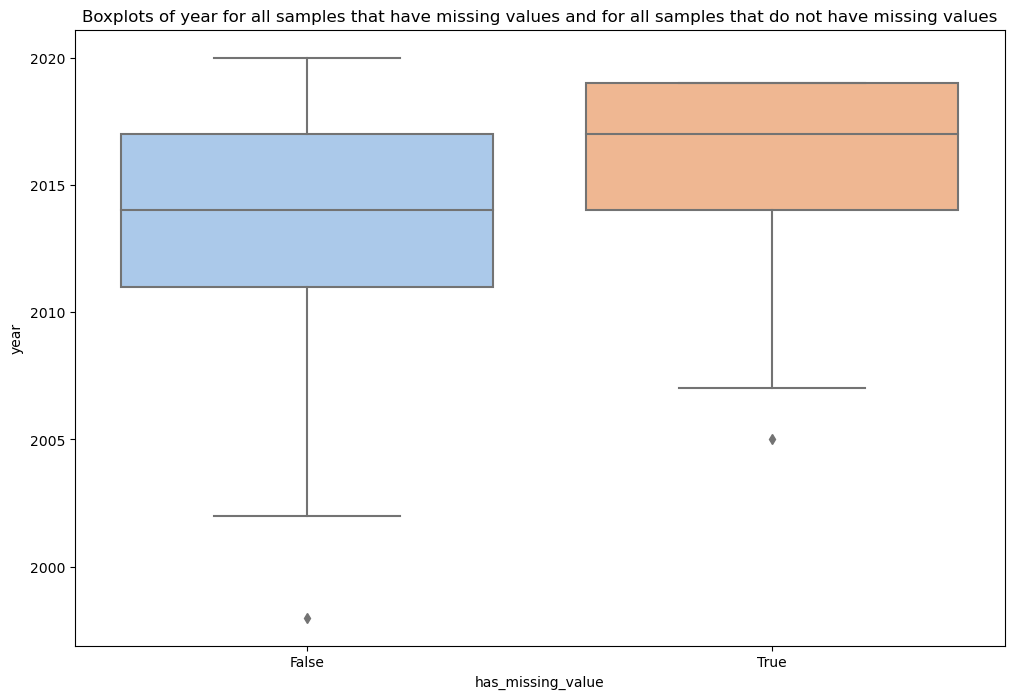

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
X_train_new = X_train.copy()
X_train_new['has_missing_value'] = X_train_new['max_power'].isna()

sns.boxplot(data=X_train_new, x = 'has_missing_value', y='year', palette = 'pastel')
plt.title('Boxplots of year for all samples that have missing values and for all samples that do not have missing values')
plt.ylabel('year')
plt.show()

<!-- END QUESTION -->

<a id="part1q2"></a>

## <div class='exercise'><b> Question 2:   Imputation Methods [45 pts]</b></div>

[Return to contents](#contents)

We will try different ways of dealing with missing data. Take care not to overwrite the original `X_train` and `X_test` as we'll want to use them each time we try a new imputation method.

<div class='exercise-r'>

    

**2.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_meanimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_meanimp_r2` 
    
**NOTE:** For the sake of consistency, we will used standardized data throughout question 2 (consider why this is necessary for at least some of our models and imputation methods). Note that we are fitting our scaler on *all* the data (train + test).
    
</div>

_Points:_ 12

In [10]:
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,year,mileage,max_power
0,0.306,-0.515,1.297
1,0.816,-1.508,NaN
2,1.072,1.209,-0.412
3,-1.226,0.085,-1.503
4,0.051,-0.876,NaN


In [11]:
#scaler = StandardScaler().fit(np.concatenate([y_train.values, y_test.values], axis=0).reshape(-1,1))
#y_train_scaled = scaler.transform(pd.DataFrame(y_train))
#y_test_scaled = scaler.transform(pd.DataFrame(y_test))
#y_train_scaled = pd.Series(y_train_scaled.flatten())
#y_test_scaled = pd.Series(y_test_scaled.flatten())

In [12]:
#Use SimpleImputer to impute the mean of observed max_power values in the training dataset for both X_train and X_test.

s_imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#s_imp_mean.fit(np.concatenate([X_train_scaled.values, X_test_scaled.values], axis=0))
s_imp_mean.fit(np.concatenate([X_train_scaled.values], axis=0))
X_train_scaled_imp_mean = pd.DataFrame(s_imp_mean.transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_scaled_imp_mean = pd.DataFrame(s_imp_mean.transform(X_test_scaled), columns=X_test_scaled.columns)

max_power_train_imp_2_4 = X_train_scaled_imp_mean['max_power'] # for Q2.4
max_power_train_nna_2_4 = X_train_scaled['max_power'].dropna(axis=0) # for Q2.4

X_train_scaled_imp_mean.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


,year,mileage,max_power
0,0.306,-0.515,1.297
1,0.816,-1.508,0.006
2,1.072,1.209,-0.412
3,-1.226,0.085,-1.503
4,0.051,-0.876,0.006


In [13]:
#Fit a linear regression model and store its R2 score on the test data in linreg_meanimp_r2

model_2_1_L = LinearRegression() 
model_2_1_L.fit(X_train_scaled_imp_mean, y_train)
y_pred_2_1_L = model_2_1_L.predict(X_test_scaled_imp_mean) # predict y from scaled X test with lin reg model
linreg_meanimp_r2 = r2_score(y_test, y_pred_2_1_L) # test set R-squared

In [14]:
#Fit a k-NN regression model (k=2) store its R2 score on the test data in knn_meanimp_r2

model_2_1_K = KNeighborsRegressor(n_neighbors=2)
model_2_1_K.fit(X_train_scaled_imp_mean, y_train)
y_pred_2_1_K = model_2_1_K.predict(X_test_scaled_imp_mean) # predict y from scaled X test with kNN model
knn_meanimp_r2 = r2_score(y_test, y_pred_2_1_K) # test set R-squared

In [15]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**2.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_knnimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_knnimp_r2` 
</div>

_Points:_ 12

In [16]:
# Use KNNImputer (k=2) to impute both X_train and X_test.

knn_imp = KNNImputer(missing_values=np.nan, n_neighbors=2)
#knn_imp.fit(np.concatenate([X_train_scaled.values, X_test_scaled.values], axis=0))
knn_imp.fit(np.concatenate([X_train_scaled.values], axis=0))
X_train_scaled_knn_imp = pd.DataFrame(knn_imp.transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_scaled_knn_imp = pd.DataFrame(knn_imp.transform(X_test_scaled), columns=X_test_scaled.columns)

X_train_scaled_imp_mean.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


,year,mileage,max_power
0,0.306,-0.515,1.297
1,0.816,-1.508,0.006
2,1.072,1.209,-0.412
3,-1.226,0.085,-1.503
4,0.051,-0.876,0.006


In [17]:
#Fit a linear regression model and store its R2 score on the test data in linreg_knnimp_r2

model_2_2_L = LinearRegression() 
model_2_2_L.fit(X_train_scaled_knn_imp, y_train)
y_pred_2_2_L = model_2_2_L.predict(X_test_scaled_knn_imp) # predict y from scaled X test with lin reg model
linreg_knnimp_r2 = r2_score(y_test, y_pred_2_2_L) # test set R-squared

In [18]:
#Fit a k-NN regression model (k=2) store its R2 score on the test data in knn_knnimp_r2

model_2_2_K = KNeighborsRegressor(n_neighbors=2)
model_2_2_K.fit(X_train_scaled_knn_imp, y_train)
y_pred_2_2_K = model_2_2_K.predict(X_test_scaled_knn_imp) # predict y from scaled X test with kNN model
knn_knnimp_r2 = r2_score(y_test, y_pred_2_2_K) # test set R-squared

In [19]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

    
**2.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates whether each row has any missing value.
  - Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_indic_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_indic_r2` 
    
</div>

_Points:_ 12

In [20]:
#For both the training and testing data, create an additional predictor called has_missing_value
#that indicates whether each row has any missing value.

scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled['is_na'] = ~X_train_scaled.index.isin(X_train_scaled.dropna(axis=0).index)
X_test_scaled['is_na'] = ~X_test_scaled.index.isin(X_test_scaled.dropna(axis=0).index)

X_test_scaled.head()

,year,mileage,max_power,is_na
0,1.072,0.065,NaN,True
1,0.051,1.209,-0.568,False
2,-0.715,-0.359,-0.884,False
3,0.051,0.404,-0.682,False
4,0.051,1.522,-0.410,False


In [21]:
#Impute the mean of observed max_power values in the training dataset for both X_train and X_test.
s_imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
s_imp_mean.fit(np.concatenate([X_train_scaled.values], axis=0))
#s_imp_mean.fit(np.concatenate([X_train_scaled.values, X_test_scaled.values], axis=0))
X_train_scaled_imp_mean = pd.DataFrame(s_imp_mean.transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_scaled_imp_mean = pd.DataFrame(s_imp_mean.transform(X_test_scaled), columns=X_test_scaled.columns)
X_train_scaled_imp_mean['is_na'] = X_train_scaled['is_na']
X_test_scaled_imp_mean['is_na'] = X_test_scaled['is_na']

X_test_scaled_imp_mean.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


,year,mileage,max_power,is_na
0,1.072,0.065,0.006,True
1,0.051,1.209,-0.568,False
2,-0.715,-0.359,-0.884,False
3,0.051,0.404,-0.682,False
4,0.051,1.522,-0.410,False


In [22]:
#Fit a linear regression model and store its R2 score on the test data in linreg_indic_r2

model_2_3_L = LinearRegression() 
model_2_3_L.fit(X_train_scaled_imp_mean, y_train)
y_pred_2_3_L = model_2_3_L.predict(X_test_scaled_imp_mean) # predict y from scaled X test with lin reg model
linreg_indic_r2 = r2_score(y_test, y_pred_2_3_L) # test set R-squared

In [23]:
#Fit a k-NN regression model (k=2) store its R2 score on the test data in knn_indic_r2

model_2_3_K = KNeighborsRegressor(n_neighbors=2)
model_2_3_K.fit(X_train_scaled_imp_mean, y_train)
y_pred_2_3_K = model_2_3_K.predict(X_test_scaled_imp_mean) # predict y from scaled X test with kNN model
knn_indic_r2 = r2_score(y_test, y_pred_2_3_K) # test set R-squared

In [24]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** Compare the $R^2$ values in **2.1** and **2.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random? Why or why not?
    
</div>

_Points:_ 9

In [25]:
# Display your results
pd.DataFrame([
    {'missingness approach': 'mean imputation',
     'linreg test $R^2$': linreg_meanimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'knn imputation',
     'linreg test $R^2$': linreg_knnimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'missingness indicator + mean imputation',
     'linreg test $R^2$': linreg_indic_r2,
     'knn test $R^2$': knn_indic_r2}, 
]).set_index('missingness approach')

,linreg test $R^2$,knn test $R^2$
missingness approach,,
mean imputation,0.189,0.621
knn imputation,0.205,0.621
missingness indicator + mean imputation,0.395,0.653


Text(0, 0.5, 'Samples')

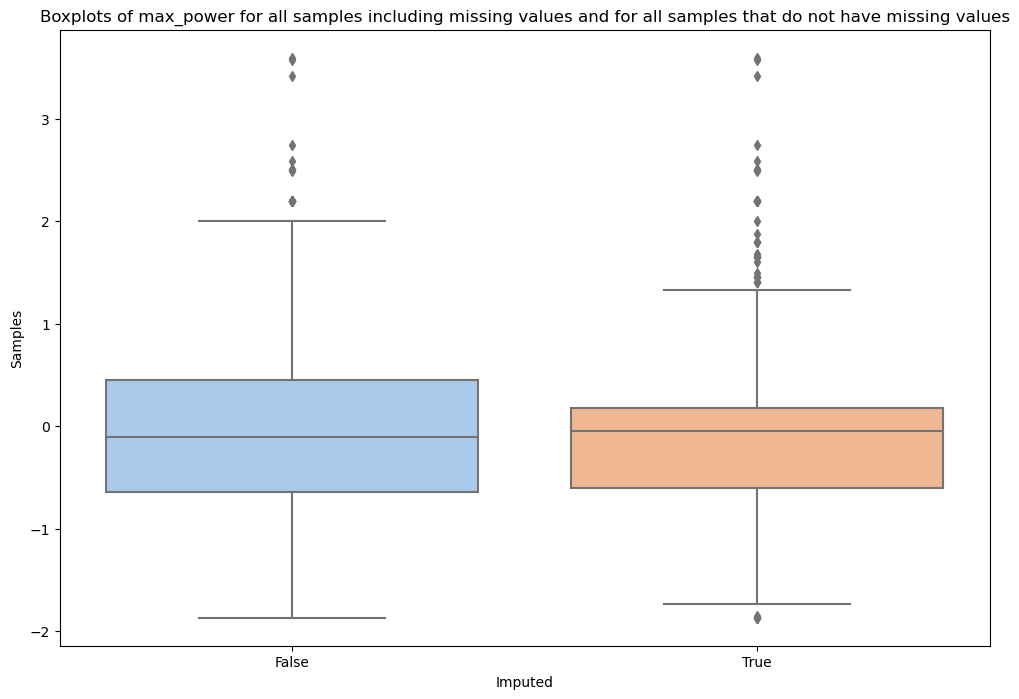

In [26]:
df_dropped_undropped = pd.DataFrame(max_power_train_nna_2_4)
df_dropped_undropped['Imputed'] = False
df_dropped_dropped = pd.DataFrame(max_power_train_imp_2_4)
df_dropped_dropped['Imputed'] = True

df_dropped_both = pd.concat([df_dropped_undropped, df_dropped_dropped])

fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(data = df_dropped_both, x = 'Imputed', y = 'max_power', palette = 'pastel')

plt.title("Boxplots of max_power for all samples including missing values and for all samples that do not have missing values")

plt.ylabel('Samples')

In [27]:
# Display your results
pd.DataFrame([
    {'Dataset': 'With Imputed Values',
     'std(max_power)': max_power_train_imp_2_4.std()},
    {'Dataset': 'Missing Values Excluded',
     'std(max_power)': max_power_train_nna_2_4.std()},
]).set_index('Dataset')

,std(max_power)
Dataset,
With Imputed Values,0.926
Missing Values Excluded,0.984


__The presence of an indicator variable more than doubles the $R^2$ for the linear regression on the test data and more modestly increases the $R^2$ for the k-NN regression on the test data. If the `max_power` data were missing completely at random, the imputed values might be expected to be close to the real values, implying that the missingness indicator would not correlate with the imputed values.__ 

__However, the missingness indicator _does_, in fact, correlate with the imputed values! All the missing `max_power` values are imputed to the mean of `max_power` in the training set. That is the reason that the standard deviation of `max_power` is less for the dataset that includes the imputed values for `max_power` than the standard deviation of `max_power` in the dataset with `NaN` values dropped. The indicator value is correlated with the center-seeking imputed value, and therefore might either help or merely overfit the model. It follows that we cannot draw a conclusion from the missingness indicator about whether the values are missing completely at random.__

<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [45 pts]: Principal Component Analysis

[Return to contents](#contents)

<a id="part2q3"></a>

## <div class='exercise'><b> Question 3: PCA for Regression [35 pts]</b></div>

[Return to contents](#contents)
 

In this question, we will be using a dataset called "Communities and Crime" adapted from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). The modified dataset contains 122 predictor variables and 1 response variable. All numeric data was normalized into the decimal range 0.00-1.00. Some of the predictor variables are:

- `householdsize`: mean people per household
- `medIncome`: median household income
- `PctHousOccup`: percent of housing occupied
- `RentMedian`: rental housing - median rent
- `PolicReqPerOffic`: total requests for police per police officer

And the response variable is 

- `ViolentCrimesPerPop`: total number of violent crimes per 100K popuation


In [28]:
# Load the datasets
df = pd.read_csv("data/communities_and_crime.csv", index_col = 0)
df.head(5)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,...,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,...,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.10,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,...,0.93,0.38,0.05,0.21,0.23,0.30,0.61,0.89,0.15,0.01,0.06,0.12,0.10,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
2,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,...,0.96,0.12,0.05,0.11,0.35,0.08,0.80,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
3,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,...,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.70,0.45,0.03,0.05,0.33,0.13,0.57,1.00,1.00,0.07,0.15,1.00,0.35,0.73,0.0,0.31,0.21,0.69
4,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,...,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0.00,0.00,0.00,0.00,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


In [29]:
# Separate predictors and response
X, y = df.drop(columns=['ViolentCrimesPerPop']), df['ViolentCrimesPerPop']
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="part2q3solution"></a>
## Question 3: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? 
    
Store these pairs in a dictionary called `high_corr` where the keys are tuples corresponding to the names of the pair of predictors and the values are the correlation between each pair.
    
</div>

_Points:_ 6

In [30]:
X_train_corr_abs = X_train.corr().abs()
high_corr = {}

for i in range(len(X_train_corr_abs)-1):
    for j in range(i+1, len(X_train_corr_abs)):
        if X_train_corr_abs.iloc[i,j] > 0.99:
            high_corr.update({(X_train_corr_abs.columns[i],X_train_corr_abs.columns[j]):\
                              X_train_corr_abs.iloc[i,j]})
            
print("The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:")

display(high_corr)

The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:


{('population', 'numbUrban'): 0.9997647561886096,
 ('PctRecentImmig', 'PctRecImmig5'): 0.9920034327871089,
 ('PctRecImmig5', 'PctRecImmig8'): 0.9963359613654262,
 ('PctRecImmig5', 'PctRecImmig10'): 0.9900961766413996,
 ('PctRecImmig8', 'PctRecImmig10'): 0.9965871515033231,
 ('OwnOccLowQuart', 'OwnOccMedVal'): 0.9917227618576423,
 ('RentMedian', 'MedRent'): 0.9930215184921779,
 ('LemasSwornFT', 'LemasSwFTFieldOps'): 0.990313653958998,
 ('LemasSwFTPerPop', 'PolicPerPop'): 0.9999911313418828}

In [31]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Fit a linear regression model on the **unscaled** training data **using all available predictors**. Store the train and test $R^2$ scores in `linreg_train_r2` and `linreg_test_r2` respectively. Interpret your results.
    
</div>

_Points:_ 6

__The training $R^2$ of $0.8461$ suggests that the model (based on all 122 avaliable predictors)
explains about 85% of the variance in the data. The fact that the test $R^2$ is dramatically lower
at $0.2186$ suggests that the model is grossly overfitted, and a more realistic model, using non-correlated
predictors, would probably explain something closer to 22% than 85% of the variance.__

In [32]:
model_3_2 = LinearRegression().fit(X_train, y_train)

y_train_pred_3_2 = model_3_2.predict(X_train) # predict y from scaled X test with lin reg model
y_test_pred_3_2 = model_3_2.predict(X_test) # predict y from scaled X test with lin reg model

linreg_train_r2 = r2_score(y_train, y_train_pred_3_2) # training set R-squared
linreg_test_r2 = r2_score(y_test, y_test_pred_3_2) # training set R-squared

print(f"linear regression train R^2: {linreg_train_r2:.4f}")
print(f"linear regression test R^2: {linreg_test_r2:.4f}")

linear regression train R^2: 0.8461
linear regression test R^2: 0.2186


In [33]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>


**3.3.1** Standardize both **X_train** and **X_test**, *fitting the scaler on all the data*, and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 

  - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
    
  - Apply the PCA transformation to the standardized **X_train**.
    
  - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
    
  Plot the mean validation MSE for each $k$. Store the best $k$ based on the mean validation MSE as `best_k`.
    
</div>

_Points:_ 14

In [34]:
scaler = StandardScaler().fit(np.concatenate([X_train.values, X_test.values], axis=0))
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
# Add back column names lost during scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [35]:
from sklearn.metrics import mean_squared_error

k_values = [1,2,3,4,5,6,8,10,12,15,20]
val_mses_mean = []

for k in k_values:
    pca = PCA(n_components = k).fit(X_train_scaled) # fit PCA transformation with n_components=k
    X_train_pca = pca.transform(X_train_scaled) # apply PCA transformation to X_train_scaled
    linreg_3_3_1 = LinearRegression().fit(X_train_pca, y_train) # fit linear regression model on transformed training data
    y_train_pred_pca = linreg_3_3_1.predict(X_train_pca)
    xval = cross_validate(linreg_3_3_1, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')
    val_mses_mean.append(-xval['test_score'].mean())

#val_mses_mean

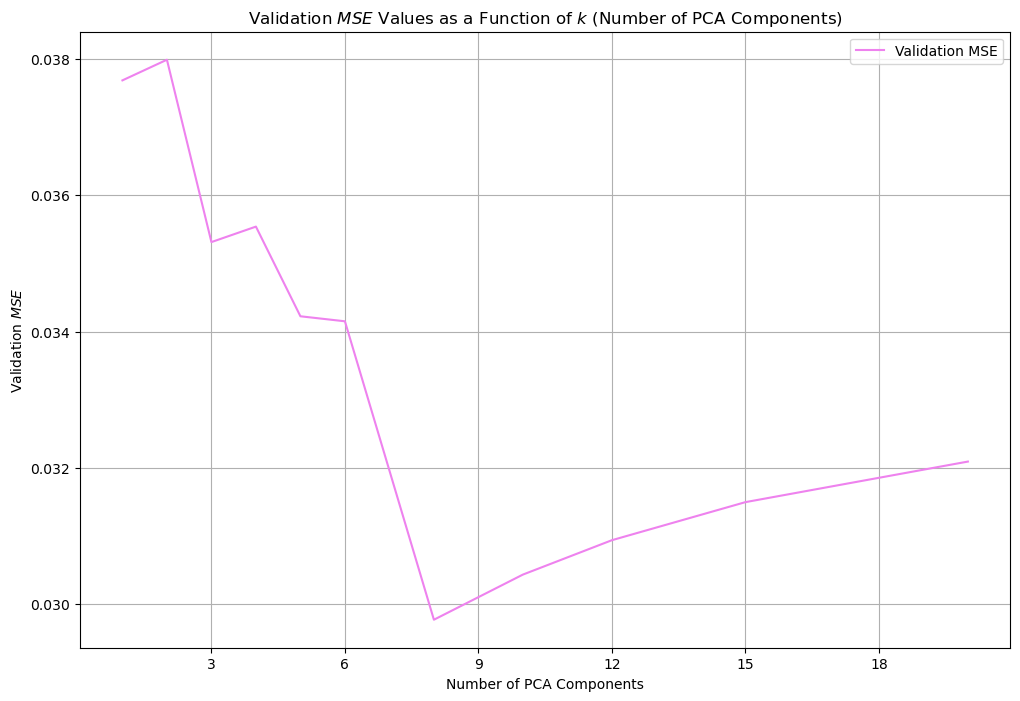

In [36]:
from matplotlib.ticker import MaxNLocator

# This code block plots training and validation mean squared error (MSE) for each k.
y_min = int(np.floor(min(val_mses_mean)))
y_max = int(np.ceil(max(val_mses_mean)))

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(k_values, val_mses_mean, label='Validation MSE', color='violet')
ax.set_xlabel('Number of PCA Components')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_ylabel('Validation $MSE$')
ax.set_title('Validation $MSE$ Values as a Function of $k$ (Number of PCA Components)')
ax.grid()
ax.legend(loc='best')
#plt.show()

In [37]:
best_k = int(k_values[np.argmin(val_mses_mean)])
print(f"The best k is {best_k}.")

The best k is 8.


In [38]:
grader.check("q3.3.1")

q3.3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>
    

**3.3.2** Now let's compute the $R^2$ value on the testing data:
  - Fit the PCA transformation on the standardized **X_train** with n_components equal to the best $k$ above.
  - Apply the PCA transformation to the standardized **X_train** and the standardized **X_test**. 
  - Fit a linear regression model to the PCA-transformed components. Store the train and test $R^2$ scores in `pcr_train_r2` and `pcr_test_r2` respectively.
    
</div>

_Points:_ 6

In [39]:
pcr_train_r2 = []
pcr_test_r2 = []

pca = PCA(n_components = best_k).fit(X_train_scaled) # fit PCA transformation with n_components=best_k

X_train_pca = pca.transform(X_train_scaled) # apply PCA transformation to X_train_scaled
X_test_pca = pca.transform(X_test_scaled) # apply PCA transformation to X_test_scaled

linreg_3_3_2 = LinearRegression().fit(X_train_pca, y_train) # fit linear regression model on transformed training data

y_train_pred_pca = linreg_3_3_2.predict(X_train_pca)
y_test_pred_pca = linreg_3_3_2.predict(X_test_pca)

pcr_train_r2 = r2_score(y_train, y_train_pred_pca) # training set R-squared
pcr_test_r2 = r2_score(y_test, y_test_pred_pca) # training set R-squared

In [40]:
# your code here
...
pcr_train_r2 = r2_score(y_train, y_train_pred_pca) # training set R-squared
pcr_test_r2 = r2_score(y_test, y_test_pred_pca) # training set R-squared
print(f"PCR train R^2: {pcr_train_r2:.4f}")
print(f"PCR test R^2: {pcr_test_r2:.4f}")

PCR train R^2: 0.6377
PCR test R^2: 0.6858


In [41]:
grader.check("q3.3.2")

q3.3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.4** Compare the $R^2$ value obtained from **3.2** (original predictors) and **3.3.2** (PCR). Provide an explanation for the observed difference in these results.
    
</div>

_Points:_ 3

In [42]:
# Display your results
pd.DataFrame([
    {'model': 'linear regression (original predictors)',
     'train $R^2$': linreg_train_r2,
     'test $R^2$': linreg_test_r2},
    {'model': f'PCR (k={best_k})',
     'train $R^2$': pcr_train_r2,
     'test $R^2$': pcr_test_r2},
]).set_index('model')

,train $R^2$,test $R^2$
model,,
linear regression (original predictors),0.846,0.219
PCR (k=8),0.638,0.686


__The original linear regression grossly overstated its training $R^2$. That model was based on 122
different predictors, of which nine (9) pairs were highly correlated. It was overwhelmingly likely
that the model was overfitted, a conjecture seemingly confirmed by the dramatically-smaller $R^2$
on the randomly-selected test data.__

__The eight-component PCA, fitted to the training data, showed a test $R^2$ that was somewhat _higher_
than the training $R^2$. As the test $R^2$ was not dramatically higher, this anomaly is probably not 
cause for concern, though it might have been prudent to verify on other test-train splits. The important
lesson, from the information available, is that this PCA model is probably more robust than our
overfitted linear regression model to test data drawn from the same population.__

<!-- END QUESTION -->

<a id="part2q4"></a>

## <div class='exercise'><b> Question 4: Visualizing Transformed Data [10 pts]</b></div>

[Return to contents](#contents)

In this question, we will be using a dataset called "Better Life Index" adapted from [Organisation for Economic Co-operation and Development](https://stats.oecd.org/). The modified dataset contains 24 numerical variables and 1 categorical variable. The categorical variable `Country` is the name of the country. Some of the numerical variables include:

- `Dwellings without basic facilities`
- `Housing expenditure`
- `Rooms per person`
- `Household net adjusted disposable income`
- `Household net financial wealth`
- ...

In [43]:
# Load and inspect the datasets
df = pd.read_csv("data/OECD_well-being.csv", index_col = 0)
print('df shape:', df.shape)
df.head()

df shape: (38, 25)


,Country,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net financial wealth,Labour market insecurity,Employment rate,Long-term unemployment rate,Personal earnings,Quality of support network,Educational attainment,Student skills,Years in education,Air pollution,Water quality,Stakeholder engagement for developing regulations,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care
0,Australia,1.1,20,2.3,33417,57462,4.3,72,1.36,52063,94,80,502,21.2,5,92,2.7,91,82.5,85,7.3,63.6,1.0,13.20,14.35
1,Austria,1.0,21,1.6,32544,59574,2.7,72,1.94,48295,92,85,492,17.1,16,93,1.3,75,81.3,70,7.0,80.7,0.4,6.78,14.55
2,Belgium,2.3,21,2.2,29968,104084,4.8,62,3.98,49587,92,75,503,18.2,15,84,2.2,89,81.1,75,6.9,70.7,1.0,4.31,15.77
3,Canada,0.2,22,2.5,29850,85758,3.9,73,0.81,48403,93,91,523,16.7,7,91,3.0,68,81.5,88,7.3,80.9,1.4,3.73,14.41
4,Chile,9.4,18,1.9,16588,21409,8.1,62,2.02,28434,84,65,443,17.3,16,69,1.5,49,79.1,57,6.7,51.1,4.5,10.06,14.90


In [44]:
# Separate predictors and response
country, X = df['Country'], df.drop(columns='Country').values

<div class='exercise-r'>

**4.1** Standardize **X** and apply a PCA transformation with n_components = 2 to your standardized data. Save the transformed data as `X_transformed`.
    
</div>


_Points:_ 2

In [45]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components=2).fit(X_scaled) # fit PCA transformation with n_components=2

X_transformed = pca.transform(X_scaled)

#X_transformed

In [46]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. The plot should state the amount of variance explained by each component. 

Label each point by its corresponding country name. Do you observe any pattern in the scatter plot? Be specific and explain.
    
</div>

_Points:_ 6

__The scatter plot suggests a 'U' shape overall; the points seem to be roughly divided into three clusters:__

1. A cluster strongly negative along the first principal component $(-4<\text{PCA1}<-1)$ but more moderately valued above and below the mean of the second principal component $(-1<\text{PCA2}<2)$ seems to be mainly centered around Western European countries and North America.

2. A cluster below and above the mean of the first principal component $(-1<\text{PCA1}<4)$ and below the mean of the second principal component $(\text{PCA2}<0)$ seems to be centered mainly in Eastern Europe, Asia, and Latin America.

3. A cluster very strongly positive along the first principal component $(4<\text{PCA1}<10)$ and positive on the second principal component $(\text{PCA2}>0)$ includes a few countries in Eastern Europe, Latin America, and Africa.

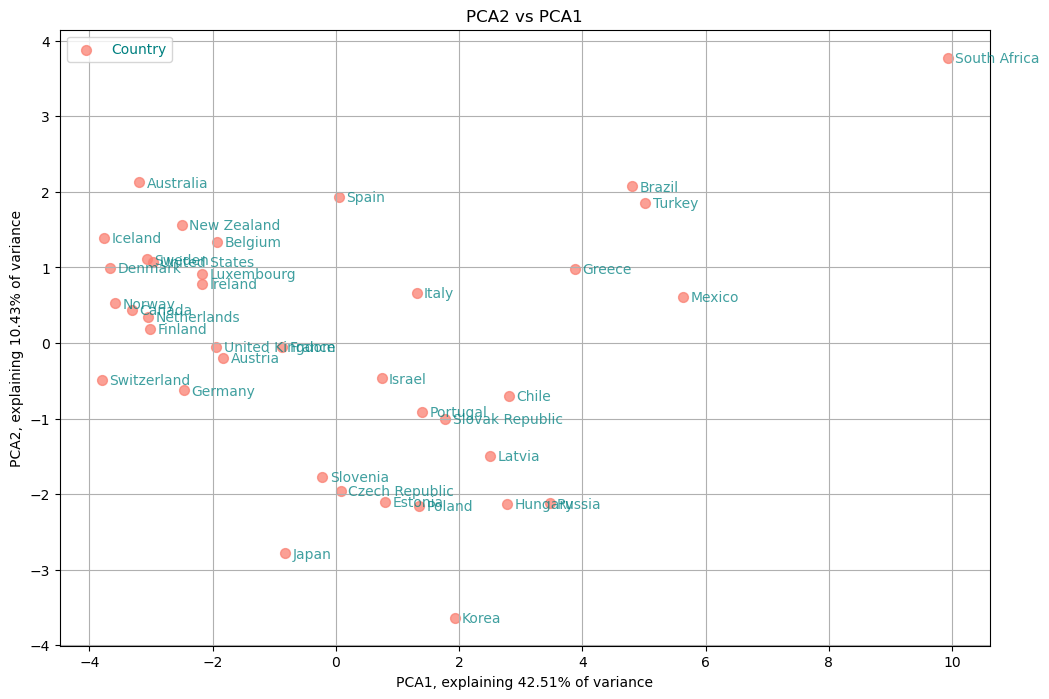

In [47]:
X_transformed_df = pd.DataFrame(X_transformed, columns=['PCA1', 'PCA2'])
X_transformed_df.insert(0,'Country',country)

varpct1 = pca.explained_variance_ratio_[0]*100
varpct2 = pca.explained_variance_ratio_[1]*100

fig, ax = plt.subplots(1, figsize=(12, 8))

ax.scatter(X_transformed_df.PCA1, X_transformed_df.PCA2, label = 'Country', s=50, c="salmon", alpha=0.75)
ax.set_xlabel(f'PCA1, explaining {varpct1:.2f}% of variance')
ax.set_ylabel(f'PCA2, explaining {varpct2:.2f}% of variance')
ax.set_title(f'PCA2 vs PCA1')

for i, label in enumerate(X_transformed_df.Country.values):
    plt.annotate(label, (X_transformed_df.PCA1[i]+0.12, X_transformed_df.PCA2[i]-0.06), c="teal", alpha=0.75)

ax.legend(loc='best', labelcolor="teal")
ax.grid()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** In question 3, where we also used PCA, we had a training and a test set. In question 4 we did not split the data. Explain why.
    
</div>

_Points:_ 2

__We don't split the data as we don't have a need to build a model to predict on the dataset. When running .isnull() on the dataset, we see that there are no missing values and so there are no value that we would need to predict. We simply want to run a PCA on the complete data set which is why we don't split the PCA into training and test sets.__

<!-- END QUESTION -->

**This concludes HW4. Thank you!**

[Return to contents](#contents)